In [1]:
import pickle

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataset
data = pd.read_csv(
    r"C:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\model-1\training_data_15k.csv"
)

C:\Users\user\AppData\Local\Temp\ipykernel_4588\2269222369.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


In [3]:
# Update class-to-id mapping for 7 classes
label_mapping = {
    "No Hate/Toxic": 0,
    "Toxic 1": 1,
    "Toxic 2": 2,
    "Toxic 3": 3,
    "Hate 1": 4,
    "Hate 2": 5,
    "Hate 3": 6,
}
# Encode gold labels
data["Classification"] = data["Classification"].astype(str)
data["Classification"] = data["Classification"].map(label_mapping)
data["text"] = data["text"].astype(str)

In [4]:
# Divide features and labels
X = data["text"]
y = data["Classification"]

In [5]:
# Split dataset into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [6]:
test_set = pd.DataFrame(X_test)
test_set["Classification"] = y_test  # Add y_test as a new column named 'target'

# Export to CSV
test_set.to_csv("test_set4.csv", index=False)

### Text Processing Function ###

In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download("punkt_tab")
nltk.download("wordnet")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    # Tokenization
    words = word_tokenize(text.lower())
    # Remove punctuation and non-alphabetic tokens
    words = [word for word in words if word.isalpha()]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Preprocess the training and test data
X_train_proc = [preprocess(text) for text in X_train]
X_test_proc = [preprocess(text) for text in X_test]
X_valid_proc = [preprocess(text) for text in X_valid]

In [8]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train_proc)

X_valid_vectorized = vectorizer.transform(X_valid_proc)
X_test_vectorized = vectorizer.transform(X_test_proc)

In [20]:
# save  vectorizer
joblib.dump(vectorizer, "vectorizer_final.pkl")

['vectorizer_final.pkl']

In [9]:
print(y_train.value_counts())

Classification
1    10500
4    10500
3    10500
2    10500
5    10500
0    10500
6    10500
Name: count, dtype: int64


## Classification Models ##

### RidgeClassifierCV ###

In [ ]:
from sklearn.model_selection import KFold

# Train the classifier
cv = KFold(n_splits=5, shuffle=True, random_state=42)
clf = RidgeClassifierCV(alphas=(3.0, 4.0, 5.0, 6.0, 7.0), cv=cv)
clf.fit(X_train_vectorized, y_train)

# Predict on the test data
y_pred_ridge = clf.predict(X_test_vectorized)

# Output the best alpha selected by RidgeClassifierCV
print("Best alpha chosen by RidgeClassifierCV:", clf.alpha_)

# Evaluate the predictions on test data
print("Test Accuracy: %s" % accuracy_score(y_test, y_pred_ridge))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_ridge, average="weighted"))
print(
    "Test Classification Report:\n",
    classification_report(
        y_test, y_pred_ridge, target_names=list(label_mapping.keys())
    ),
)

# Predict on the validation data
y_val_pred_ridge = clf.predict(X_valid_vectorized)

# Evaluate the predictions on validation data
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_ridge))
print(
    "Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_ridge, average="weighted")
)
print(
    "Validation Classification Report:\n",
    classification_report(
        y_valid, y_val_pred_ridge, target_names=list(label_mapping.keys())
    ),
)

Best alpha chosen by RidgeClassifierCV: 4.0
Test Accuracy: 0.8104126984126984
Test F1-Score: 0.8149010203438865
Test Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.62      0.74      0.67      2250
      Toxic 1       0.54      0.60      0.57      2250
      Toxic 2       0.90      0.69      0.78      2250
      Toxic 3       1.00      0.98      0.99      2250
       Hate 1       0.73      0.75      0.74      2250
       Hate 2       0.99      0.94      0.97      2250
       Hate 3       1.00      0.98      0.99      2250

     accuracy                           0.81     15750
    macro avg       0.83      0.81      0.81     15750
 weighted avg       0.83      0.81      0.81     15750

Validation Accuracy: 0.8006349206349206
Validation F1-Score: 0.8056645275314659
Validation Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.60      0.73      0.66      2250
      Toxic 1       0.53 

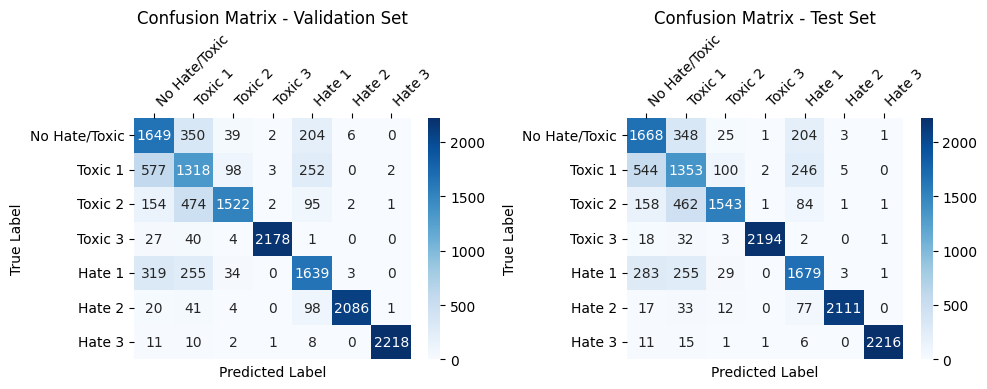

In [39]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_ridge)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_ridge)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

plt.tight_layout()
plt.show()

In [43]:
# Save the trained model to a file
joblib.dump(clf, "ridge_classifier_model.pkl")
print("Model saved as ridge_classifier_model.pkl")

Model saved as ridge_classifier_model.pkl


### XGBoost ###

In [ ]:
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",  # Multiclass classification
    num_class=7,  # Number of classes (7)
    eval_metric="mlogloss",  # Multiclass log-loss as evaluation metric
    use_label_encoder=False,  # Disable label encoding warning
)

# Define parameter grid for GridSearchCV
param_grid = {
    "xgb__max_depth": [5, 7],  # Control the complexity of the trees
    "xgb__learning_rate": [0.1, 0.2],  # Speed of model learning
    "xgb__n_estimators": [100, 200],  # Number of trees in the ensemble
    "xgb__subsample": [0.5, 0.7],  # Subsampling for robustness
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=2,  # 3-fold cross-validation for speed
    verbose=1,  # Show progress
    n_jobs=-1,  # Use all available cores
)

# Fit the grid search to the raw text data
grid_search.fit(X_train_vectorized, y_train)

# Get the best parameters found by GridSearchCV
print("Best parameters found:", grid_search.best_params_)

# Predict on the test data using the best model
y_pred_best = grid_search.best_estimator_.predict(X_test_vectorized)

print("Accuracy: %s" % accuracy_score(y_test, y_pred_best))
print(
    classification_report(y_test, y_pred_best, target_names=list(label_mapping.keys()))
)
print("Test F1-Score weighted: %s" % f1_score(y_test, y_pred_best, average="weighted"))

# Predict on the validation set to evaluate performance
y_val_pred_best = grid_search.best_estimator_.predict(X_valid_vectorized)
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_best))
print(
    classification_report(
        y_valid, y_val_pred_best, target_names=list(label_mapping.keys())
    )
)
print(
    "Validation F1-Score weighted: %s"
    % f1_score(y_valid, y_val_pred_best, average="weighted")
)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder", "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.5}
Accuracy: 0.7972698412698412
               precision    recall  f1-score   support

No Hate/Toxic       0.55      0.77      0.65      2250
      Toxic 1       0.53      0.54      0.54      2250
      Toxic 2       0.89      0.67      0.77      2250
      Toxic 3       0.99      0.98      0.98      2250
       Hate 1       0.77      0.69      0.73      2250
       Hate 2       0.99      0.94      0.96      2250
       Hate 3       1.00      0.98      0.99      2250

     accuracy                           0.80     15750
    macro avg       0.82      0.80      0.80     15750
 weighted avg       0.82      0.80      0.80     15750

Test F1-Score weighted: 0.8019021308440243
Validation Accuracy: 0.7927619047619048
               precision    recall  f1-score   support

No Hate/Toxic       0.54      0.77      0.64      2250
      Toxic 1       0.52      0.53      0.52    

In [12]:
# Save the best model (the entire pipeline with TF-IDF and XGBoost) to a file
joblib.dump(grid_search.best_estimator_, "best_xgb_model.pkl")
print("Model saved as best_xgb_model.pkl")

Model saved as best_xgb_model.pkl


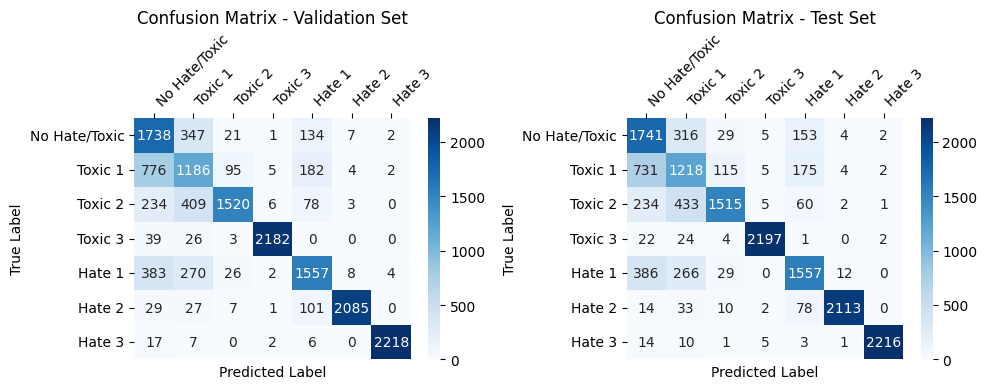

In [13]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_best)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_best)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Naive Bayes Classifier ###

Multinomial Naive Bayes classifier - A generative classifier which models how a class could generate some input data. Given an observation, they return the class most likely to have generated the observation

In [12]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

nb.fit(X_train_vectorized, y_train)

# Predict on the test set
y_pred_nb = nb.predict(X_test_vectorized)
# Predict on the validation set
y_val_pred_nb = nb.predict(X_valid_vectorized)

# Evaluate the predictions
print("Test Accuracy: %s" % accuracy_score(y_pred_nb, y_test))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_nb, average="weighted"))
print(classification_report(y_test, y_pred_nb, target_names=list(label_mapping.keys())))
print("Validation Accuracy: %s" % accuracy_score(y_val_pred_nb, y_valid))
print("Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_nb, average="weighted"))
print(
    classification_report(
        y_valid, y_val_pred_nb, target_names=list(label_mapping.keys())
    )
)

Test Accuracy: 0.7998095238095239
Test F1-Score: 0.8045955834872026
               precision    recall  f1-score   support

No Hate/Toxic       0.66      0.62      0.64      2250
      Toxic 1       0.52      0.66      0.58      2250
      Toxic 2       0.91      0.65      0.76      2250
      Toxic 3       0.99      0.98      0.98      2250
       Hate 1       0.67      0.76      0.71      2250
       Hate 2       0.99      0.94      0.96      2250
       Hate 3       1.00      0.98      0.99      2250

     accuracy                           0.80     15750
    macro avg       0.82      0.80      0.80     15750
 weighted avg       0.82      0.80      0.80     15750

Validation Accuracy: 0.7907301587301587
Validation F1-Score: 0.7960681644628341
               precision    recall  f1-score   support

No Hate/Toxic       0.63      0.62      0.63      2250
      Toxic 1       0.50      0.63      0.56      2250
      Toxic 2       0.90      0.65      0.75      2250
      Toxic 3       0.9

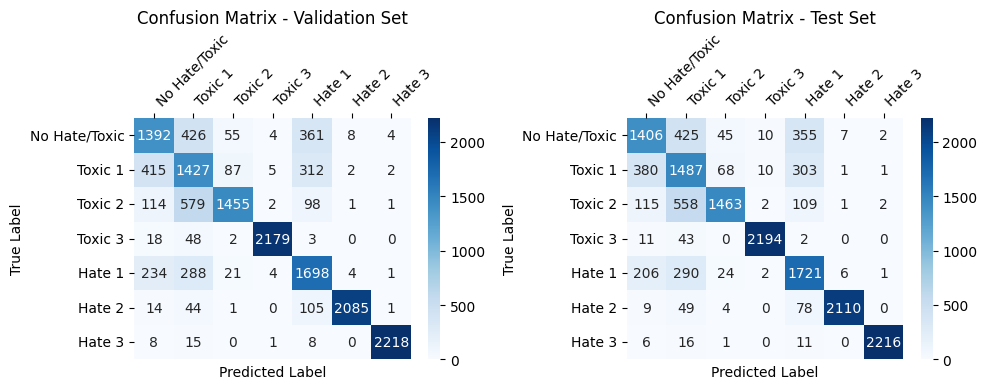

In [13]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_nb)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_nb)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # <-- Added this line

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],  # Specify the subplot
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],  # Specify the subplot
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Linear SVM ###

In [11]:
sgd = SGDClassifier(
    loss="hinge",
    penalty="l2",
    alpha=1e-3,
    random_state=42,
    max_iter=5,
    tol=None,
)

# Fit the model to the training data
sgd.fit(X_train_vectorized, y_train)

# Predict on the test set
y_pred_svm = sgd.predict(X_test_vectorized)
# Predict on the validation set
y_val_pred_svm = sgd.predict(X_valid_vectorized)

# Evaluate the predictions
print("Test Accuracy: %s" % accuracy_score(y_pred_svm, y_test))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_svm, average="weighted"))
print(
    classification_report(y_test, y_pred_svm, target_names=list(label_mapping.keys()))
)
print("Validation Accuracy: %s" % accuracy_score(y_val_pred_svm, y_valid))
print("Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_svm, average="weighted"))
print(
    classification_report(
        y_valid, y_val_pred_svm, target_names=list(label_mapping.keys())
    )
)

Test Accuracy: 0.7551111111111111
Test F1-Score: 0.7420169903621204
               precision    recall  f1-score   support

No Hate/Toxic       0.63      0.57      0.60      2250
      Toxic 1       0.58      0.33      0.42      2250
      Toxic 2       0.67      0.71      0.69      2250
      Toxic 3       0.90      0.98      0.94      2250
       Hate 1       0.64      0.77      0.70      2250
       Hate 2       0.85      0.94      0.90      2250
       Hate 3       0.92      0.99      0.95      2250

     accuracy                           0.76     15750
    macro avg       0.74      0.76      0.74     15750
 weighted avg       0.74      0.76      0.74     15750

Validation Accuracy: 0.7501587301587301
Validation F1-Score: 0.7383380507442484
               precision    recall  f1-score   support

No Hate/Toxic       0.61      0.56      0.58      2250
      Toxic 1       0.57      0.35      0.43      2250
      Toxic 2       0.67      0.71      0.69      2250
      Toxic 3       0.9